# Set-up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F

# Import data

In [2]:
scapis = pd.read_csv('data/processed_data/scapis_joined_preprocessed.csv')
igt = pd.read_csv('data/processed_data/igt_joined_preprocessed.csv')
metadata = pd.read_csv('data/processed_data/metadata_preprocessed.csv')

In [3]:
igt_in = igt.drop(columns=['DAid'])
igt_in['Sex'] = igt_in['Sex'].map({'F': 0, 'M': 1})
igt_in['Smoke_status'] = igt_in['Smoke_status'].map({'NEVER': 0, 'EX_SMOKER': 1, 'CURRENT': 2})

igt_in.head()

,Sex,Age,Smoke_status,MAP_Mean,HbA1c,Chol,LDL,HDL,TG,ALT,...,GUSB,SCARF1,CELA3A,CCN3,HYOU1,LILRB2,ST6GAL1,TIE1,SIRPA,CASP3
0,0,59,1,78,35,4.7,3.0,1.90,0.76,0.19,...,-0.5040,-0.2106,0.0820,-0.0710,0.1003,0.1606,-0.4113,-2.0221,-0.3631,-1.1320
1,0,57,0,131,33,4.9,2.9,1.70,1.50,0.40,...,-0.3155,0.3637,0.7343,0.2531,0.0328,0.3409,-0.2604,0.2079,-1.0626,0.0286
2,1,51,1,103,42,6.8,3.6,0.98,4.30,0.54,...,2.0403,0.7059,0.8228,0.7173,0.1993,-0.0336,0.1411,0.8053,-0.0228,0.3960
3,0,54,1,92,34,7.2,5.4,1.40,2.00,0.33,...,-0.3515,0.0699,1.0066,0.6701,0.1653,-0.0150,0.3154,-0.0527,0.3685,-0.0582
4,1,54,2,83,37,4.2,2.8,0.96,0.81,0.49,...,-0.1522,0.2425,0.9367,0.1271,0.1272,0.1541,0.0736,-0.0461,-0.8490,-0.8921


# Neural Network

In [4]:
class Model(nn.Module):
    def __init__(self, in_features=1487, h1=1024, h2=612, h3=256, h4=64, out_features=2, dropout_rate=0.2):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(h1, h2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(h2, h3)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(h3, h4)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(h4, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.out(x)
        return x

In [5]:
# Weight initialization function
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [6]:
def balance_groups(data, variable, case=1, seed=123):
    np.random.seed(seed)
    
    # Split data into cases and controls
    case_data = data[data[variable] == case]
    control_data = data[data[variable] != case]
    
    # Determine the number of case samples
    case_sample_num = len(case_data)
    
    # Sample from control data to match the number of cases, with replacement if needed
    control_sampled = control_data.sample(n=case_sample_num, replace=True, random_state=seed)
    
    # Concatenate the cases and the sampled controls
    balanced_data = pd.concat([case_data, control_sampled], axis=0).reset_index(drop=True)
    
    return balanced_data

In [7]:
torch.manual_seed(123)
model = Model()

In [8]:
variable = 'Carotid_plaque'

In [9]:
train_data, test_data = train_test_split(igt_in, test_size=0.2, random_state=123)

In [10]:
balanced_train = balance_groups(train_data, variable)

X_train = balanced_train.drop(columns=['MASLD'])
y_train = balanced_train[variable]
X_test = test_data.drop(columns=['MASLD'])
y_test = test_data[variable]

In [11]:
# Convert to numpy arrays
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [12]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [13]:
# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Add 10x cross validation to my model
kf = KFold(n_splits=10, shuffle=True, random_state=123)
kf.get_n_splits(balanced_train)

fold_losses = []
val_losses = []

for train_index, val_index in kf.split(X_train):
    
    X_cv_train, X_cv_val = X_train[train_index], X_train[val_index]
    y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]
    
    model.apply(weights_init)  # Initialize weights

    epochs = 500
    losses = []

    for i in range(epochs):
        model.train()  # Set model to training mode
        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        y_pred = model(X_cv_train)
        loss = criteria(y_pred, y_cv_train)
        losses.append(loss.item())

        if i % 10 == 0:
            print(f'Epoch {i} and loss is: {loss.item()}')

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Validation loss after training on this fold
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        y_val = model(X_cv_val)
        val_loss = criteria(y_val, y_cv_val)
        val_losses.append(val_loss.item())
    print(f'Validation Loss: {val_loss.item()}')

    fold_losses.append(losses)


Epoch 0 and loss is: 4.9234724044799805
Epoch 10 and loss is: 2.013146162033081
Epoch 20 and loss is: 1.18450129032135
Epoch 30 and loss is: 0.9715514779090881
Epoch 40 and loss is: 0.8575416207313538
Epoch 50 and loss is: 0.8361348509788513
Epoch 60 and loss is: 0.7664836645126343
Epoch 70 and loss is: 0.7643492221832275
Epoch 80 and loss is: 0.7620398998260498
Epoch 90 and loss is: 0.7354556918144226
Epoch 100 and loss is: 0.7339302897453308
Epoch 110 and loss is: 0.7209340333938599
Epoch 120 and loss is: 0.722236692905426
Epoch 130 and loss is: 0.7126305103302002
Epoch 140 and loss is: 0.719306468963623
Epoch 150 and loss is: 0.7160651087760925
Epoch 160 and loss is: 0.7158203125
Epoch 170 and loss is: 0.704704761505127
Epoch 180 and loss is: 0.6986397504806519
Epoch 190 and loss is: 0.6967877745628357
Epoch 200 and loss is: 0.6999011039733887
Epoch 210 and loss is: 0.7044224739074707
Epoch 220 and loss is: 0.7108780145645142
Epoch 230 and loss is: 0.7000476717948914
Epoch 240 and l

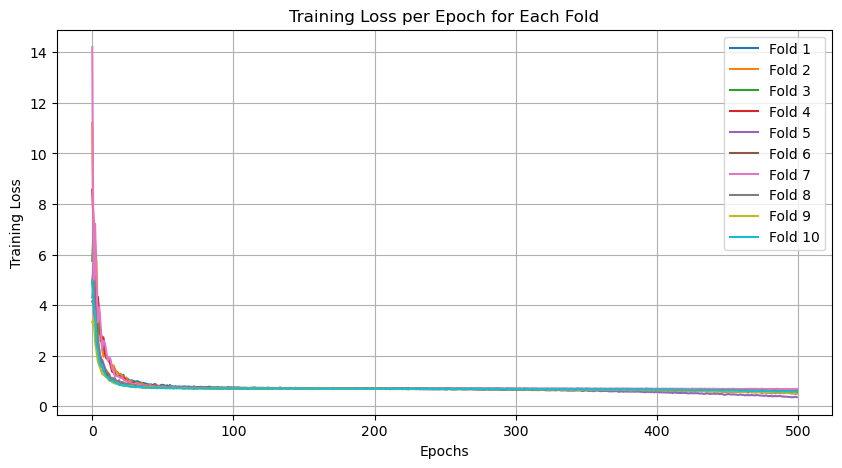

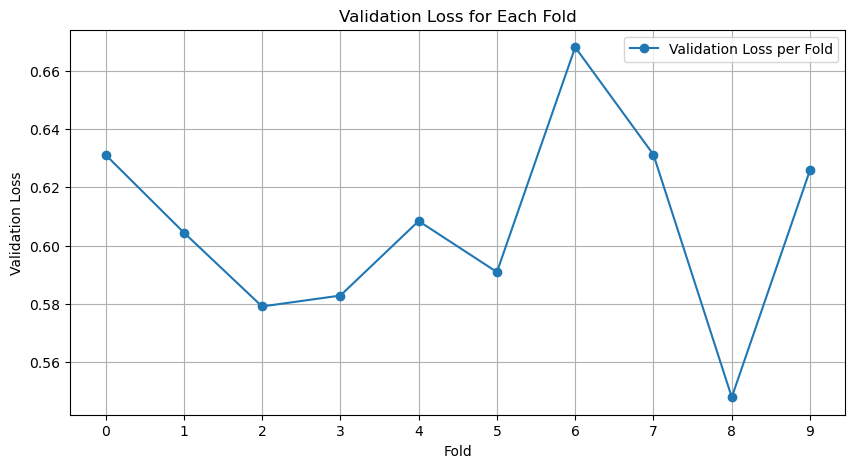

In [14]:
plt.figure(figsize=(10, 5))
for fold in range(len(fold_losses)):
    plt.plot(fold_losses[fold], label=f'Fold {fold + 1}')

plt.title('Training Loss per Epoch for Each Fold')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid()
plt.show()

# Plotting validation loss
plt.figure(figsize=(10, 5))
plt.plot(val_losses, marker='o', label='Validation Loss per Fold')
plt.title('Validation Loss for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Validation Loss')
plt.xticks(range(len(val_losses)))  # Set x-ticks to be the fold numbers
plt.legend()
plt.grid()
plt.show()

In [15]:
model.apply(weights_init)  # Re-initialize weights before final training
epochs = 500

for i in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    y_train_pred = model(X_train)
    train_loss = criteria(y_train_pred, y_train)
    
    if i % 10 == 0:
        print(f'Final Training Epoch {i} and loss is: {train_loss.item()}')
    
    train_loss.backward()
    optimizer.step()

Final Training Epoch 0 and loss is: 8.90905475616455
Final Training Epoch 10 and loss is: 1.485540509223938
Final Training Epoch 20 and loss is: 1.0066996812820435
Final Training Epoch 30 and loss is: 0.8154160380363464
Final Training Epoch 40 and loss is: 0.7776536345481873
Final Training Epoch 50 and loss is: 0.7344710230827332
Final Training Epoch 60 and loss is: 0.7360257506370544
Final Training Epoch 70 and loss is: 0.7195083498954773
Final Training Epoch 80 and loss is: 0.7148776054382324
Final Training Epoch 90 and loss is: 0.7163860201835632
Final Training Epoch 100 and loss is: 0.718170702457428
Final Training Epoch 110 and loss is: 0.7056468725204468
Final Training Epoch 120 and loss is: 0.7016608119010925
Final Training Epoch 130 and loss is: 0.7060915231704712
Final Training Epoch 140 and loss is: 0.6976953744888306
Final Training Epoch 150 and loss is: 0.6987820863723755
Final Training Epoch 160 and loss is: 0.6917345523834229
Final Training Epoch 170 and loss is: 0.694849

Test Loss: 0.6726602911949158
We got 225 out of 380 correct! Accuracy: 0.59
Sensitivity: 0.67
Specificity: 0.50
AUC: 0.61


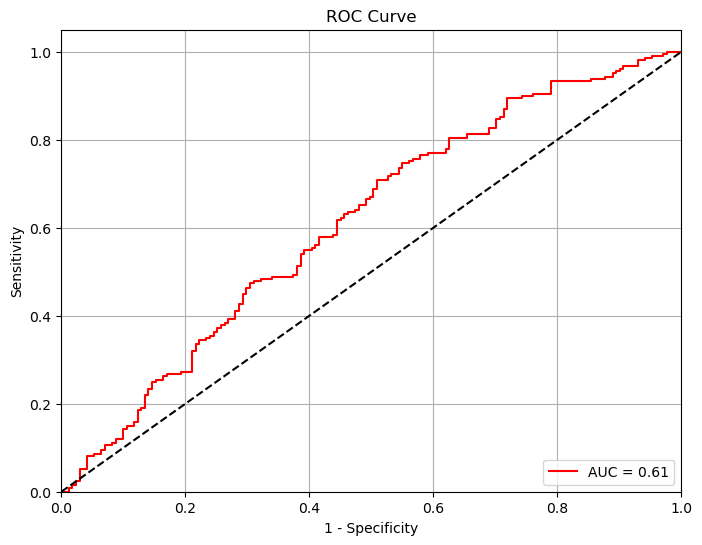

In [16]:
with torch.no_grad():  # Turn off backpropagation
    model.eval()  # Set model to evaluation mode
    y_eval = model(X_test)

    # Get predicted probabilities for the positive class (assuming binary classification)
    probabilities = F.softmax(y_eval, dim=1)[:, 1]  # Get probabilities for the positive class
    test_loss = criteria(y_eval, y_test)  # Calculate the loss
    print(f'Test Loss: {test_loss.item()}')

    # Compute accuracy
    correct = (torch.argmax(y_eval, dim=1) == y_test).sum().item()
    accuracy = correct / len(y_test)
    print(f'We got {correct} out of {len(y_test)} correct! Accuracy: {accuracy:.2f}')

    # Calculate confusion matrix
    y_pred_labels = (probabilities > 0.5).int()  # Binarize probabilities based on a threshold (0.5)
    tn, fp, fn, tp = confusion_matrix(y_test.numpy(), y_pred_labels.numpy()).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f'Sensitivity: {sensitivity:.2f}')
    print(f'Specificity: {specificity:.2f}')

    # Compute AUC
    auc = roc_auc_score(y_test.numpy(), probabilities.numpy())
    print(f'AUC: {auc:.2f}')

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test.numpy(), probabilities.numpy())

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='red', label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [17]:
#torch.save(model.state_dict(), 'models/obesity_nn.pth')